<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# WebCam Image Classification Quickstart Notebook

<br>

Image classification is a classical problem in computer vision that of determining whether or not the image data contains some specific object, feature, or activity. It is regarded as a mature research area
and currently the best models are based on [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network). Such models with weights trained on millions of images and hundreds of object classes in [ImageNet dataset](http://www.image-net.org/) are available from major deep neural network frameworks such as [CNTK](https://www.microsoft.com/en-us/cognitive-toolkit/features/model-gallery/), [fast.ai](https://docs.fast.ai/vision.models.html#Computer-Vision-models-zoo), [Keras](https://keras.io/applications/), [PyTorch](https://pytorch.org/docs/stable/torchvision/models.html), and [TensorFlow](https://tfhub.dev/s?module-type=image-classification).


This notebook shows a simple example of how to load pretrained mobel and run it on a webcam stream. Here, we use [ResNet](https://arxiv.org/abs/1512.03385) model by utilizing `fastai.vision` package.

> For more details about image classification tasks including transfer-learning (aka fine tuning), please see our [training introduction notebook](01_training_introduction.ipynb).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
import io, time
import fastai
from fastai.vision import *
from ipywebrtc import CameraStream, ImageRecorder
import ipywidgets as widgets
from torch.cuda import get_device_name
from utils_ic.datasets import imagenet_labels


print(f"Fast.ai: {fastai.__version__}")
print(get_device_name(0))

Fast.ai: 1.0.45
GeForce GTX 1050


In [3]:
IMAGE_SIZE = 224

## 1. Load Pretrained Model

We use ResNet18 which is a relatively small and fast compare to other CNNs models. The [reported error rate](https://pytorch-zh.readthedocs.io/en/latest/torchvision/models.html) of the model on ImageNet is 30.24% for top-1 and 10.92% for top-5<sup>*</sup>.

The pretrained model expects input images normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225], which is defined in `fastai.vision.imagenet_stats`.

The output of the model is the probability distribution of the classes in ImageNet. To convert them into human-readable labels, we utilize the label json file used from [Keras](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py).

> \* top-n: *n* labels considered most probable by the mode

In [4]:
labels = imagenet_labels()
print(f"Num labels = {len(labels)}")
print(f"{', '.join(labels[:5])}, ...")

Num labels = 1000
tench, goldfish, great_white_shark, tiger_shark, hammerhead, ...


In [5]:
empty_data = ImageDataBunch.single_from_classes(
    "", classes=labels, size=IMAGE_SIZE
).normalize(imagenet_stats)

learn = Learner(empty_data, models.resnet18(pretrained=True))

## 2. Classify Images


### 2.1 Image file
We use a sample image from `COCO_TINY` in `fastai.vision` just because it is a very small size and easy to download by calling a simple function, `untar_data(URLs.COCO_TINY)`.

> Original [COCO dataset](http://cocodataset.org/) is a large-scale object detection, segmentation, and captioning dataset.

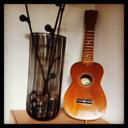

In [6]:
path = untar_data(URLs.COCO_TINY)
im = open_image(path/"train"/"000000564902.jpg", convert_mode='RGB')
im

In [7]:
_, ind, _ = learn.predict(im)
print(labels[ind])

acoustic_guitar


### 2.2 WebCam Stream

We use `ipywebrtc` to start a webcam and get the video stream to the notebook's widget. For details about `ipywebrtc`, see [this link](https://ipywebrtc.readthedocs.io/en/latest/). 

In [9]:
run_model = True

# Webcam
w_cam = CameraStream(
    constraints={
        'facing_mode': 'user',
        'audio': False,
        'video': { 'width': IMAGE_SIZE, 'height': IMAGE_SIZE }
    }
)
# Image recorder for taking a snapshot
w_imrecorder = ImageRecorder(stream=w_cam, layout=widgets.Layout(margin='0 0 0 50px'))
# Text label widget to show our classification results
w_label = widgets.Label("result label") 


def classify_frame(_):
    """ Classify an image snapshot by using a pretrained model
    """
    try:
        im = open_image(io.BytesIO(w_imrecorder.image.value), convert_mode='RGB')
        _, ind, _ = learn.predict(im)
        # Show results to the label widget 
        w_label.value = labels[ind]
    except OSError:
        # If im_recorder doesn't have valid image data, skip it. 
        pass

    if run_model:
        # Taking the next snapshot programmatically
        w_imrecorder.recording = True

# Register classify_frame as a callback. Will be called whenever image.value changes. 
w_imrecorder.image.observe(classify_frame, 'value')

In [10]:
# Show widgets
widgets.HBox([w_cam, w_imrecorder, w_label])

Now, click the **capture button** of the image recorder widget to start classification. Labels show the most probable class predicted by the model for an image snapshot.

<center>
<img src="../docs/media/webcam.png" style="width: 400px;"/>
<i>Webcam image classification example</i>
</center>

<br>

In this notebook, we have shown a quickstart example of using a pretrained model to classify images. The model, however, is not able to predict the object labels that are not part of ImageNet. From our [training introduction notebook](01_training_introduction.ipynb), you can find how to fine-tune the model to address such problems.

In [11]:
# Stop the model and webcam 
run_model = False
widgets.Widget.close_all()